In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Clean data and perform dimension reduction

In [83]:
person = 4
sadl1 = pd.read_table('data/S%d-ADL1.dat' % person, sep='\s+', header=None, dtype=float)

In [84]:
sadl1.head(10)

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0,-12,1043,70,-25,934,476,447,855,337,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,33,-18,1047,69,-9,931,462,450,861,367,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,67,-12,1043,52,-38,924,463,502,839,367,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,100,0,1021,48,-38,929,443,583,873,361,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,133,-10,1031,59,-33,918,464,664,833,389,...,NaN,NaN,NaN,0,0,0,0,0,0,0
5,167,-19,1050,59,-10,919,466,642,809,504,...,NaN,NaN,NaN,0,0,0,0,0,0,0
6,200,-10,1050,47,-38,908,476,582,819,504,...,NaN,NaN,NaN,0,0,0,0,0,0,0
7,233,-8,1048,42,-20,927,445,686,837,541,...,NaN,NaN,NaN,0,0,0,0,0,0,0
8,267,-3,1039,48,-20,939,459,695,757,563,...,NaN,NaN,NaN,0,0,0,0,0,0,0
9,300,-41,1056,39,-20,940,486,680,775,596,...,NaN,NaN,NaN,0,0,0,0,0,0,0


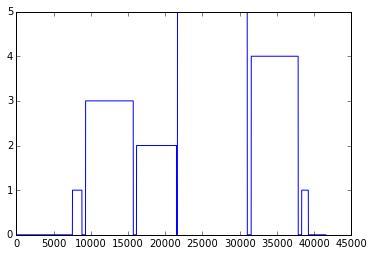

In [85]:
# feature : col 0~36, label : col 244. Column 0 is time.
plt.plot(np.maximum(sadl1.iloc[:, 244] - 100, 0)) # 0: idle, 101~105: activity
plt.show()

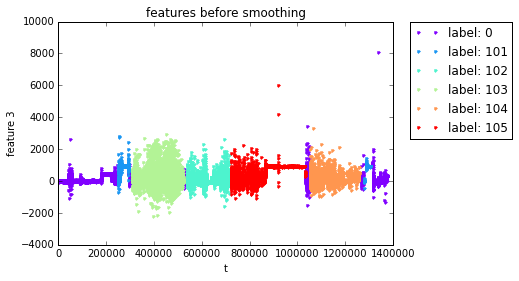

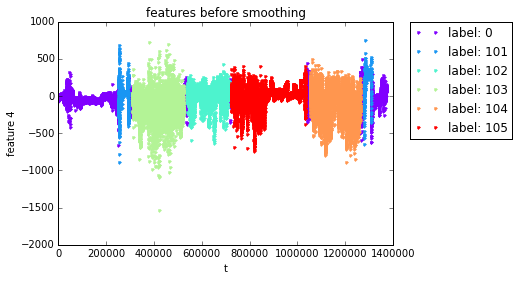

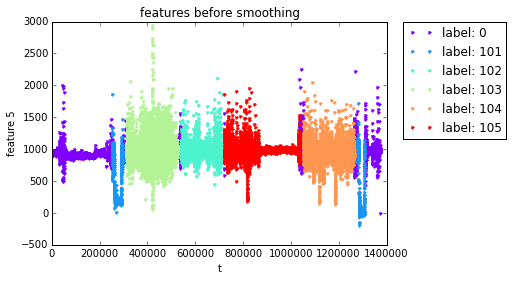

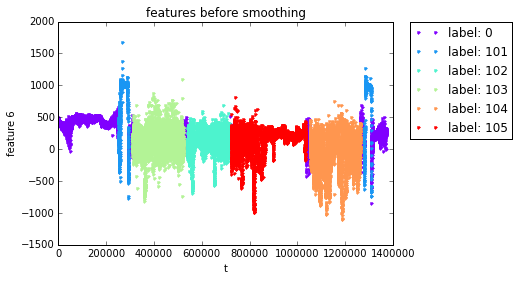

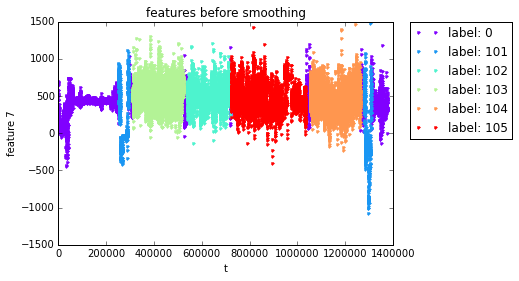

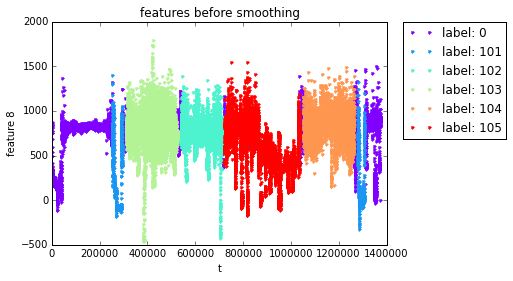

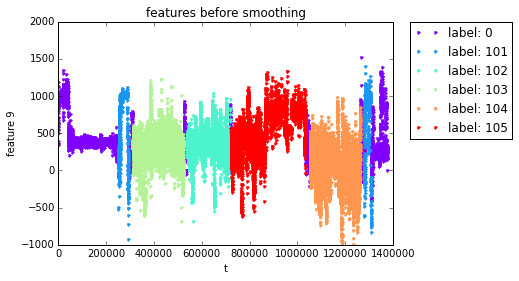

In [116]:
import matplotlib.cm as cm # color map
# plot some raw features
def feature_vs_time(t, features, labels, selected_cols, title):
    # t: time axis 1D array
    # features: 2D array
    # labels: 1D array
    label_list = [0, 101, 102, 103, 104, 105]
    colors = cm.rainbow(np.linspace(0, 1, len(label_list)))
    
    for k, col in enumerate(selected_cols):
        for i, label in enumerate(label_list):
            plt.plot(t[labels == label], features[labels == label, col], ".", c=colors[i], label="label: %d" % label)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # put legend to the right of the plot
        plt.ylabel("feature %d" % col)
        plt.xlabel("t")
        plt.title(title)
        plt.show()
        
feature_vs_time(sadl1.iloc[:, 0].values, sadl1.values, sadl1.iloc[:, 244].values, range(3, 10), "features before smoothing")
    

In [112]:
# smooth data
def moving_avg(df, n, step):
    """
    moving avg with step size
    (Did not use pandas.rolling since step size not supported.)
    Input:
    df: Input dataframe. First column (index 0) is time stamp.
    n: window length
    step: step size of the moving average
    Return:
    data: 2D array with features, has less number of rows than input df. 
    """
    T = df.shape[0]
    new_t = range(0, T, step)
    data = np.zeros((len(new_t), df.shape[1]))

    for i, t in enumerate(new_t):
        data[i, :] = np.nanmean(df.iloc[t: t + n, :].values, axis=0) # ignore nan when computing mean.
    return data

#window size: 500 ms, step size 250 ms
winsize = 15
stepsize = 8
features = moving_avg(sadl1.iloc[:, 0:37], winsize, stepsize)
t_ds, features = features[:, 0], features[:, 1:]
print features.shape
print t_ds.shape

(5199, 36)
(5199,)


In [113]:
# smooth data: take majority vote of label within each window
from scipy import stats

def moving_vote_majority(label_df, n, step):
    """
    Take majority vote of labels in the moving window.
    Input:
    label_df: dataframe with one column denoting the label stream.
    n: window size.
    step: step size of the moving window
    Return:
    labels: 1D array with labels.
    """
    T = label_df.shape[0]
    new_t = range(0, T, step)
    labels = np.zeros((len(new_t)))
    for i, t in enumerate(new_t):
        labels[i] = stats.mode(label_df.iloc[t: t + n].values)[0][0]
    return labels
labels = moving_vote_majority(sadl1.iloc[:, 244], winsize, stepsize)
print labels.shape

(5199,)


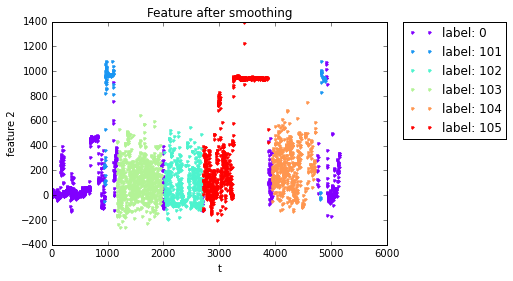

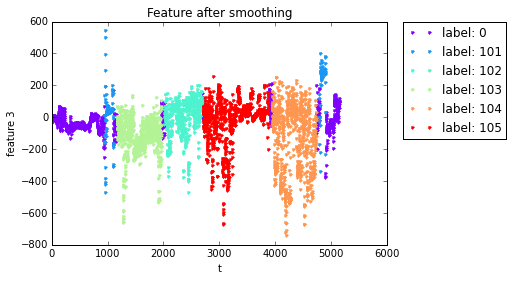

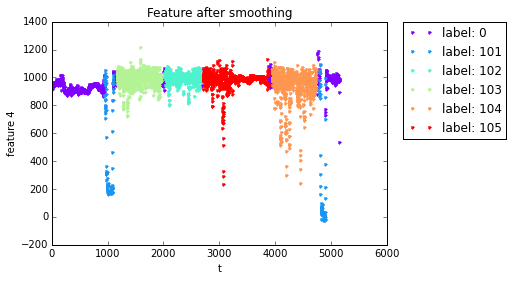

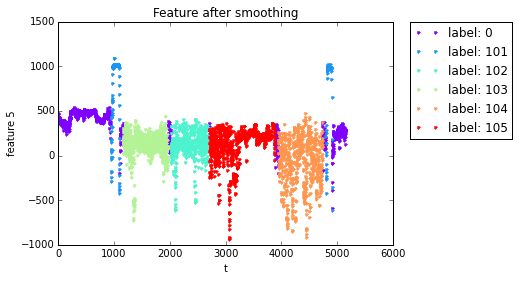

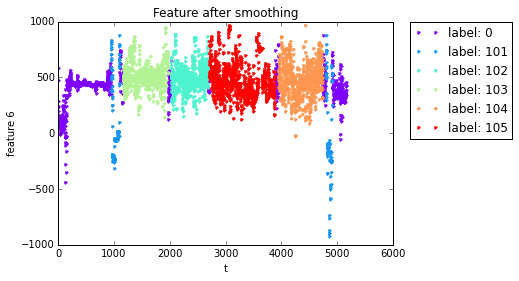

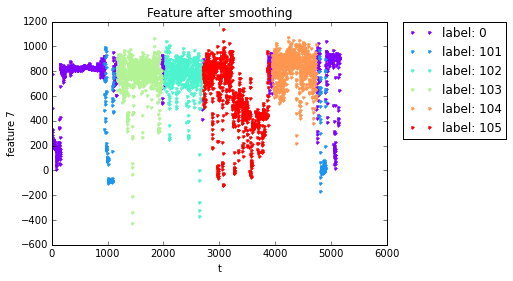

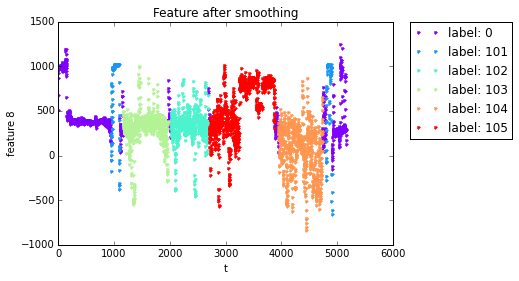

In [117]:
# plot smoothed features and labels
feature_vs_time(np.arange(0, len(labels)), features, labels, range(2, 9), "Feature after smoothing")

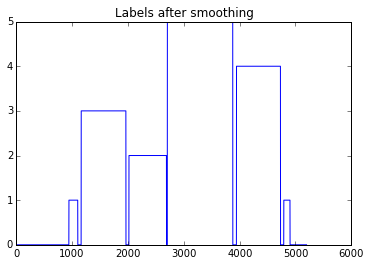

In [119]:
plt.plot(np.maximum(labels - 100, 0)) # 0: idle, 101~105: activity
plt.title('Labels after smoothing')
plt.show()

In [126]:
# Fill in the missing values
def fill_missing(training, test, col_threshold, replace):
    """
    training: 2D array
    test: 2D array or None. If test is None, only process training data.
    col_threshold: if nan values in one column is greater than col_threshold, the column is ignored.
    replace: True: replace nan value in each row. False: delete the row if it contains nan.
    """
    # delete nan columns
    training = training[:, np.sum(np.isnan(training), axis=0) < col_threshold * training.shape[0]]
    if test is not None:
        test = test[:, np.sum(np.isnan(test), axis=0) < col_threshold * test.shape[0]]

    # process nans in each row
    if not replace:
        training = training[np.logical_not(np.any(np.isnan(training), axis=1)), :]
        if test is not None:
            test = test[np.logical_not(np.any(np.isnan(test), axis=1)), :]
    else:
        # replace with previous values
        for i in range(0, training.shape[0]):
            if i == 0:
                training[i, np.isnan(training[i, :])] = 0.0
            else:
                training[i, np.isnan(training[i, :])] = training[i - 1, np.isnan(training[i, :])]
        # remove the column with zero variance
        var_train = np.var(training, axis=0)
        logical_mask = var_train > 0
        training = training[:, logical_mask]
        
        if test is not None:
            test = test[:, logical_mask]
            mean_train = np.mean(training, axis=0)
            for i in range(0, test.shape[0]):
                if i == 0:
                    # fill in the mean of training data
                    test[i, np.isnan(test[i, :])] = mean_train[np.isnan(test[i, :])]
                else:
                    test[i, np.isnan(test[i, :])] = test[i - 1, np.isnan(test[i, :])]
    
    return training, test

training, _ = fill_missing(features, None, 0.5, True)
print training.shape
print np.any(np.isnan(training))

(5199, 36)
False
